In [1]:
import pandas as pd
import xgboost
import seaborn as sns
import numpy as np
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('/Users/gabi.burabia/Downloads/surgeries to predict.csv').drop(columns = ['Unnamed: 0'])


In [3]:
df.rename(columns = {'Surgery Type': 'surgery_type',
                     'Anesthesia Type': 'anesthesia_type', 
                      'Age': 'age',
                      'BMI': 'bmi',
                     'DoctorID': 'doctor_id',
                     'AnaesthetistID': 'anaesthetist_id',
                     'Duration in Minutes': 'duration_in_minutes'
                    }, inplace= True)         

In [4]:
df.sample(3)

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes
1471,4,1,46,20,216637,338971,128
3313,2,0,44,33,314004,478204,36
4123,0,0,47,28,727378,355966,68


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   surgery_type         10000 non-null  int64
 1   anesthesia_type      10000 non-null  int64
 2   age                  10000 non-null  int64
 3   bmi                  10000 non-null  int64
 4   doctor_id            10000 non-null  int64
 5   anaesthetist_id      10000 non-null  int64
 6   duration_in_minutes  10000 non-null  int64
dtypes: int64(7)
memory usage: 547.0 KB


In [6]:
df.describe()

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.995300,0.494200,49.585400,24.429700,555664.92060,547050.830900,115.154800
std,1.414383,0.499991,9.979723,5.049258,258429.07277,258173.206729,54.472795
min,0.000000,0.000000,13.000000,4.000000,100097.00000,100058.000000,15.000000
25%,1.000000,0.000000,43.000000,21.000000,332224.25000,324239.250000,59.000000
50%,2.000000,0.000000,50.000000,24.000000,559765.00000,544535.000000,131.000000
75%,3.000000,1.000000,56.000000,28.000000,776335.50000,767940.250000,161.000000
max,4.000000,1.000000,88.000000,43.000000,999995.00000,999907.000000,242.000000


In [7]:
len(pd.unique(df['anaesthetist_id']))/len(df)

0.9943

In [8]:
len(pd.unique(df['doctor_id']))/len(df)

0.9946

<AxesSubplot:xlabel='surgery_type', ylabel='count'>

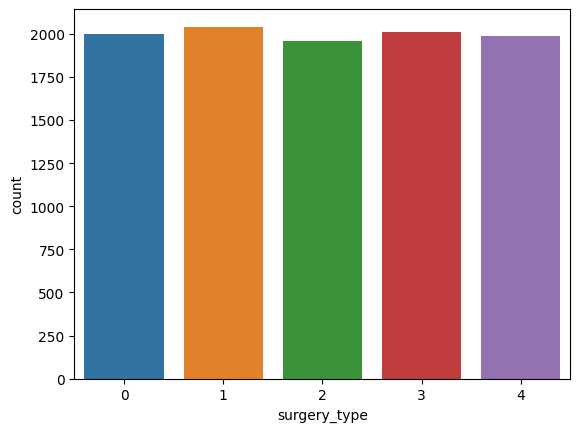

In [9]:
sns.countplot(x=df["surgery_type"])

<AxesSubplot:xlabel='anesthesia_type', ylabel='count'>

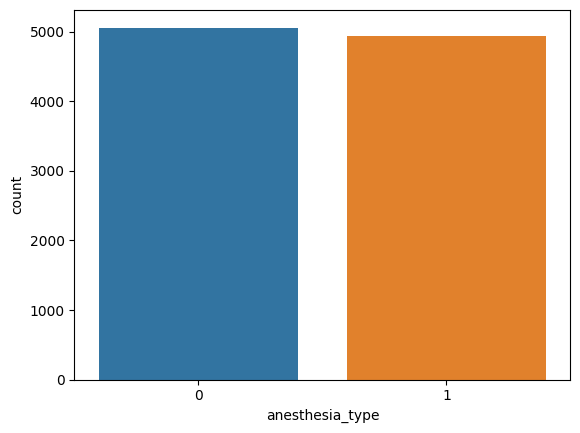

In [10]:
sns.countplot(x=df["anesthesia_type"])

<AxesSubplot:xlabel='age', ylabel='Count'>

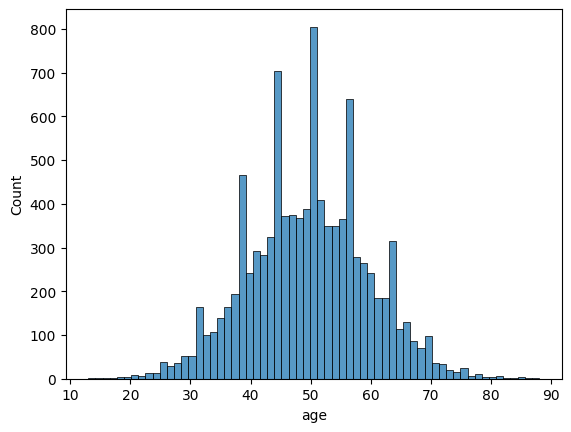

In [11]:
sns.histplot(x=df["age"])

<AxesSubplot:xlabel='bmi', ylabel='Count'>

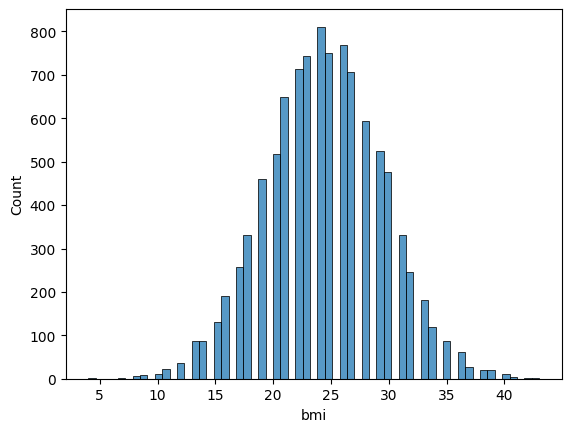

In [12]:
sns.histplot(x=df["bmi"])

<AxesSubplot:xlabel='duration_in_minutes', ylabel='Count'>

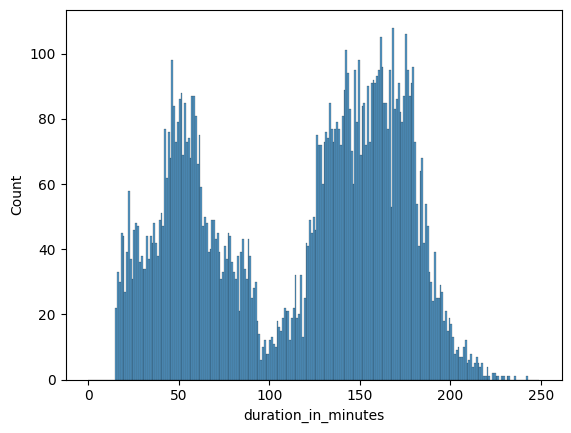

In [13]:
sns.histplot(data=df, x="duration_in_minutes", bins = range(0, 250))

<AxesSubplot:xlabel='duration_in_minutes', ylabel='surgery_type'>

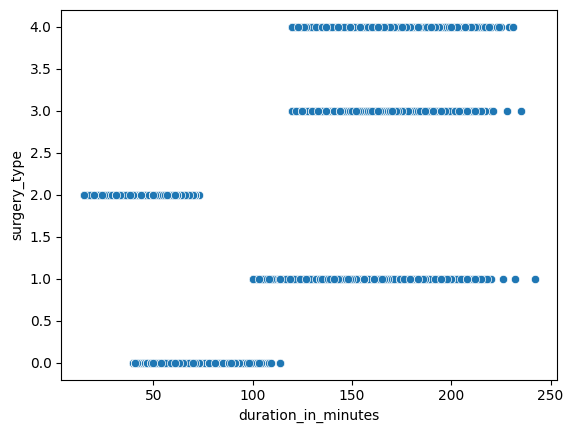

In [14]:
sns.scatterplot(data=df, x="duration_in_minutes", y="surgery_type")


<AxesSubplot:xlabel='duration_in_minutes', ylabel='age'>

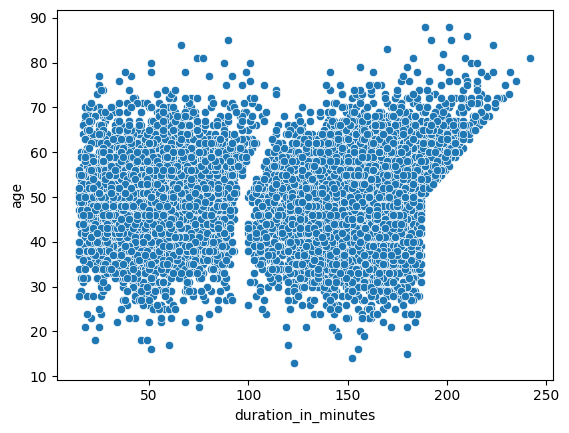

In [15]:
sns.scatterplot(data=df, x="duration_in_minutes", y="age")

<AxesSubplot:xlabel='duration_in_minutes', ylabel='bmi'>

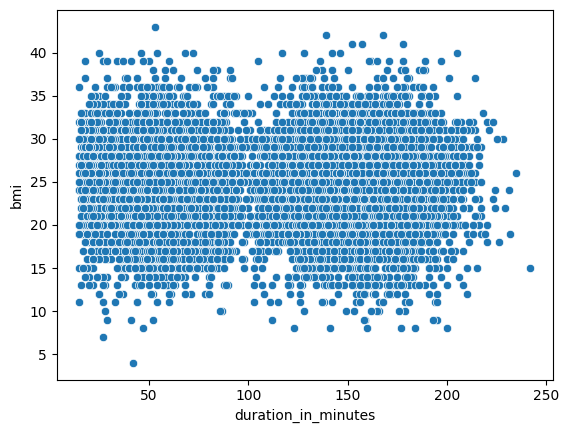

In [16]:
sns.scatterplot(data=df, x="duration_in_minutes", y="bmi")

<AxesSubplot:xlabel='duration_in_minutes', ylabel='age'>

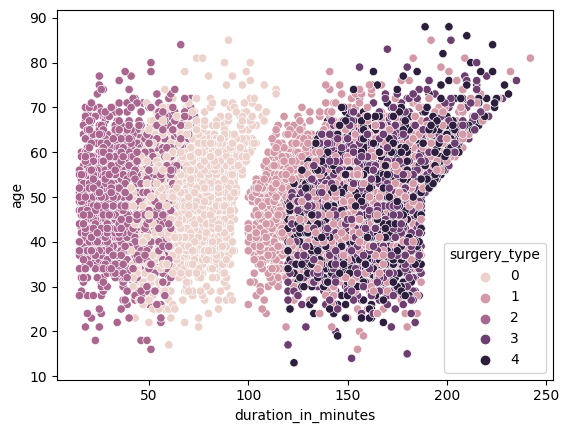

In [23]:
sns.scatterplot(data=df, x="duration_in_minutes", y="age", hue = 'surgery_type')

<AxesSubplot:xlabel='duration_in_minutes', ylabel='Count'>

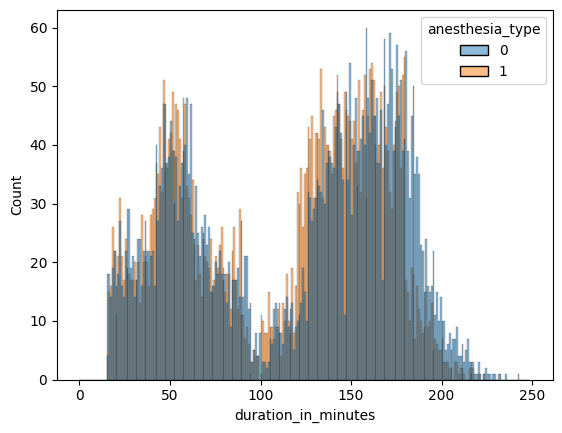

In [17]:
sns.histplot(data=df, x="duration_in_minutes", bins = range(0, 250), hue = 'anesthesia_type')

In [18]:
df.corr()

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes
surgery_type,1.000000,-0.005200,0.002703,0.008657,-0.009077,-0.018489,0.495960
anesthesia_type,-0.005200,1.000000,-0.001825,0.000651,-0.000114,-0.000550,-0.061036
age,0.002703,-0.001825,1.000000,0.002946,-0.017381,0.009682,0.097779
bmi,0.008657,0.000651,0.002946,1.000000,-0.000038,0.011659,0.009051
doctor_id,-0.009077,-0.000114,-0.017381,-0.000038,1.000000,-0.012418,-0.008414
anaesthetist_id,-0.018489,-0.000550,0.009682,0.011659,-0.012418,1.000000,-0.014957
duration_in_minutes,0.495960,-0.061036,0.097779,0.009051,-0.008414,-0.014957,1.000000


In [19]:
train_df, test_df = train_test_split(df, test_size = 0.1)
len(train_df), len(test_df)

(9000, 1000)

In [29]:
surgery_type_avg_age = train_df.groupby(['surgery_type'])['age'].mean().to_frame('avg_age').reset_index()

surgery_type_to_avg_age = dict(zip(surgery_type_avg_age.surgery_type, surgery_type_avg_age.avg_age))
surgery_type_to_avg_age

{0: 49.40011129660545,
 1: 49.54073264078732,
 2: 49.74171428571429,
 3: 49.533590308370044,
 4: 49.415929203539825}

In [32]:
train_df['diff_avg_age'] = train_df.apply(lambda row: row['age'] -  surgery_type_to_avg_age[row['surgery_type']], axis=1)
test_df['diff_avg_age'] = test_df.apply(lambda row: row['age'] -  surgery_type_to_avg_age[row['surgery_type']], axis=1)

In [33]:
features_columns = ['surgery_type', 'anesthesia_type', 'age', 'bmi', 'diff_avg_age']
target_column = 'duration_in_minutes'
train_x = train_df[features_columns]
train_y = train_df[target_column].tolist()
test_x = test_df[features_columns]
test_y = test_df[target_column].tolist()

In [34]:

surgery_type_one_hot_encoder = OneHotEncoder()

tran_surgery_type_encoded = surgery_type_one_hot_encoder.fit_transform(train_x[['surgery_type']]).toarray()

In [35]:


for i in range(tran_surgery_type_encoded.shape[1]):
    train_x[f'surgery_type_index_{i}'] = tran_surgery_type_encoded[:, i]



/Users/gabi.burabia/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
test_surgery_type_encoded = surgery_type_one_hot_encoder.transform(test_x[['surgery_type']]).toarray()

for i in range(test_surgery_type_encoded.shape[1]):

    test_x[f'surgery_type_index_{i}'] = test_surgery_type_encoded[:, i]

/Users/gabi.burabia/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [37]:
train_x.sample(3)

,surgery_type,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4
6056,0,1,35,35,-14.400111,1.0,0.0,0.0,0.0,0.0
5214,4,0,45,24,-4.415929,0.0,0.0,0.0,0.0,1.0
7497,0,1,41,17,-8.400111,1.0,0.0,0.0,0.0,0.0


In [38]:
test_x.sample(3)

,surgery_type,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4
6027,2,1,39,27,-10.741714,0.0,0.0,1.0,0.0,0.0
9303,2,0,34,32,-15.741714,0.0,0.0,1.0,0.0,0.0
3802,2,0,70,27,20.258286,0.0,0.0,1.0,0.0,0.0


In [39]:

cols = ['surgery_type']

surgery_type_target_encoder = TargetEncoder(cols = cols, smoothing = 0.3)
train_surgery_type_target_encoded = surgery_type_target_encoder.fit_transform(train_x, train_y)['surgery_type']

train_x['surgery_type_target_encoded'] = train_surgery_type_target_encoded


train_x.drop(columns = ['surgery_type'], inplace = True)

train_x.sample(1)


,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4,surgery_type_target_encoded
5970,1,46,18,-3.400111,1.0,0.0,0.0,0.0,0.0,68.220924


In [40]:
test_surgery_type_target_encoded = surgery_type_target_encoder.transform(test_x)['surgery_type']
test_x['surgery_type_target_encoded'] = test_surgery_type_target_encoded


test_x.drop(columns = ['surgery_type'], inplace = True)

test_x.sample(1)

,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4,surgery_type_target_encoded
2841,0,71,30,21.459267,0.0,1.0,0.0,0.0,0.0,148.166758


In [41]:
test_x.sample(3)

,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4,surgery_type_target_encoded
4469,0,56,26,6.258286,0.0,0.0,1.0,0.0,0.0,39.229714
1751,1,48,26,-1.533590,0.0,0.0,0.0,1.0,0.0,159.047357
8679,0,38,24,-11.540733,0.0,1.0,0.0,0.0,0.0,148.166758


In [86]:

model = xgboost.XGBRegressor(n_estimators=100, max_depth=5, subsample = 0.4, colsample_bytree=0.5)

model.fit(train_x, train_y)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [87]:
test_x.sample(2)

,anesthesia_type,age,bmi,diff_avg_age,surgery_type_index_0,surgery_type_index_1,surgery_type_index_2,surgery_type_index_3,surgery_type_index_4,surgery_type_target_encoded
9098,0,48,21,-1.741714,0.0,0.0,1.0,0.0,0.0,39.229714
2465,1,49,25,-0.741714,0.0,0.0,1.0,0.0,0.0,39.229714


In [88]:
train_scores = model.predict(train_x)
test_scores = model.predict(test_x)

In [89]:
mean_absolute_error(train_scores, train_y), mean_absolute_error(test_scores, test_y)

(14.800940005408393, 16.943514755249023)

In [90]:
train_df['score'] = train_scores
test_df['score'] = test_scores

In [91]:
test_df.sample(1)

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes,diff_avg_age,score
9531,1,0,69,23,988687,410496,198,19.459267,160.826202


<AxesSubplot:xlabel='duration_in_minutes', ylabel='score'>

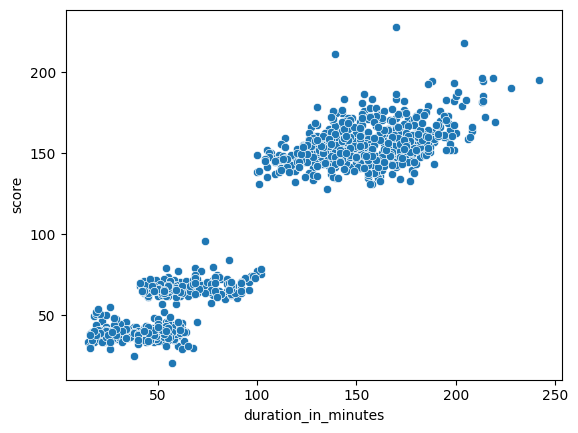

In [92]:
sns.scatterplot(data=test_df, x="duration_in_minutes", y="score")

<AxesSubplot:xlabel='duration_in_minutes', ylabel='score'>

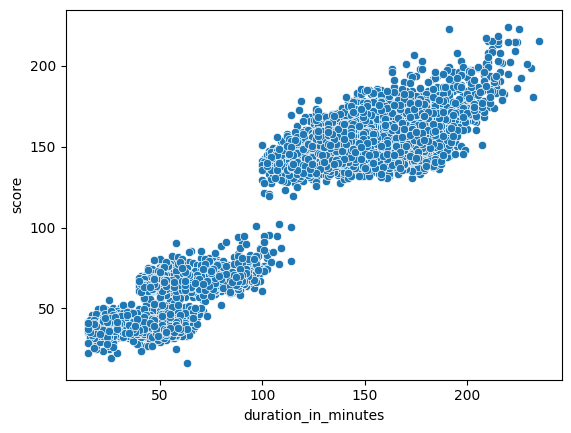

In [93]:
sns.scatterplot(data=train_df, x="duration_in_minutes", y="score")

<AxesSubplot:xlabel='duration_in_minutes', ylabel='score'>

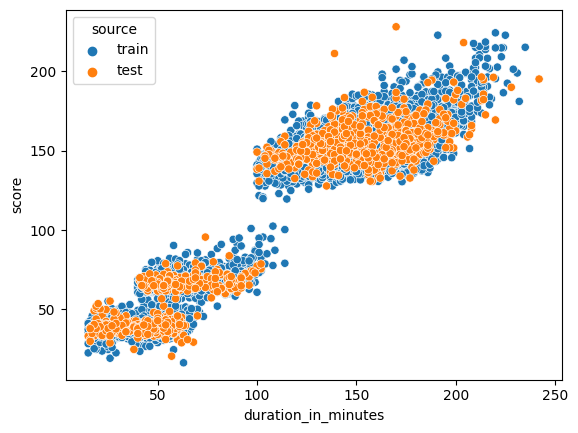

In [94]:
train_df['source'] = 'train'
test_df['source'] = 'test'


all_predictions_df = pd.concat([train_df, test_df])
sns.scatterplot(data=all_predictions_df, x="duration_in_minutes", y="score", hue = 'source')


In [59]:
train_df.sample(1)

,surgery_type,anesthesia_type,age,bmi,doctor_id,anaesthetist_id,duration_in_minutes,score,source
2855,0,1,34,31,339058,625296,85,64.528419,train


<AxesSubplot:xlabel='duration_in_minutes', ylabel='score'>

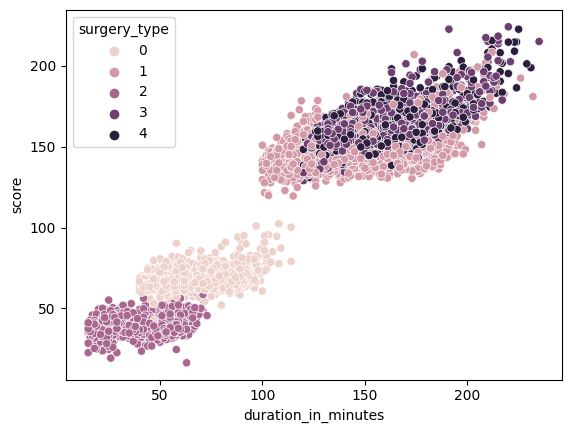

In [95]:
sns.scatterplot(data=train_df, x="duration_in_minutes", y="score", hue = 'surgery_type')

<AxesSubplot:xlabel='duration_in_minutes', ylabel='score'>

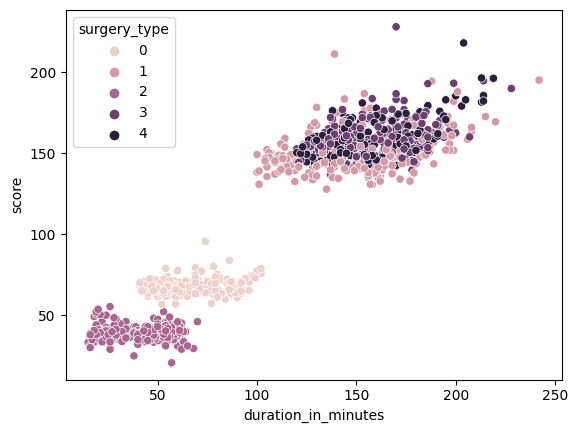

In [96]:
sns.scatterplot(data=test_df, x="duration_in_minutes", y="score", hue = 'surgery_type')

In [97]:
all_predictions_df['diff'] = np.abs(all_predictions_df['duration_in_minutes'] - all_predictions_df['score'])

all_predictions_df['percent'] = all_predictions_df['diff']/all_predictions_df['duration_in_minutes']

<AxesSubplot:xlabel='duration_in_minutes', ylabel='diff'>

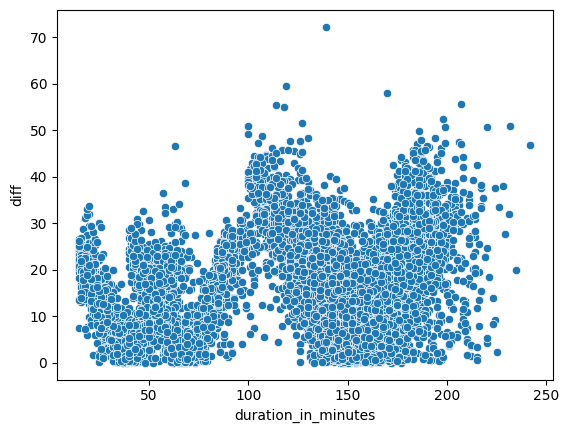

In [98]:
sns.scatterplot(data=all_predictions_df, x="duration_in_minutes", y="diff")


<AxesSubplot:xlabel='duration_in_minutes', ylabel='percent'>

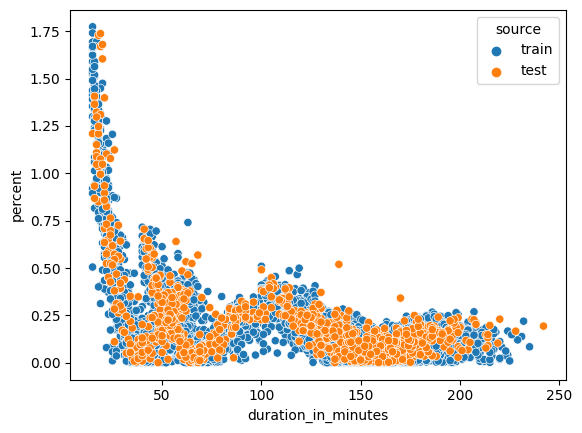

In [99]:
sns.scatterplot(data=all_predictions_df, x="duration_in_minutes", y="percent", hue = 'source')

<AxesSubplot:xlabel='percent', ylabel='Count'>

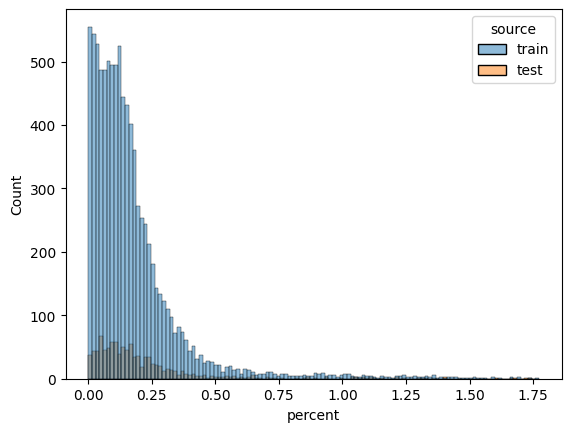

In [100]:
sns.histplot(data=all_predictions_df, x="percent", hue = 'source')